<a href="https://colab.research.google.com/github/realfolkcode/random-convex-graphs/blob/main/random_convex_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
from __future__ import print_function
from IPython.display import clear_output
import torch
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
from time import time
from random import choice
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy.spatial import Delaunay
from copy import copy
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import tensorflow as tf
from tensorflow import keras
import pandas as pd
#from queue import Queue

import warnings
warnings.filterwarnings("ignore")

# Embedding to graph

## Implementation

In [2]:
import random

In [3]:
def emb_to_graph(emb):
    n = emb.shape[0]
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    for i in range(n):
        for j in range(n):
            if np.linalg.norm(emb[i] - emb[j], ord=1) == 1:
                G.add_edge(i, j)
    return G

In [4]:
def ba_space_rect(n, d):
    # Initialize two neughboring points that lie on the same axis
    emb = np.zeros((n, d))
    emb[1][0] = 1
    free = [0, 1]
    degrees = [1, 1]
    # Mapping from coordinates to idx (if exists)
    occupied = {}
    occupied[tuple(emb[0])] = 0
    occupied[tuple(emb[1])] = 1

    i = 2
    while i < n:
        idx = np.random.choice(free, p=degrees / np.sum(degrees))
        neighbors = []
        for k in range(d):
            tmp = emb[idx].copy()
            tmp[k] -= 1
            if tuple(tmp) not in occupied:
                neighbors.append(-k)
            tmp = emb[idx].copy()
            tmp[k] += 1
            if tuple(tmp) not in occupied:
                neighbors.append(k)
        if len(neighbors) > 0:
            k = np.random.choice(neighbors)
            emb[i] = emb[idx]
            if k < 0:
                emb[i][-k] -= 1
            else:
                emb[i][k] += 1
            occupied[tuple(emb[i])] = i
            free.append(i)
            deg_i = 0
            for k in range(d):
                tmp = emb[i].copy()
                tmp[k] -= 1
                if tuple(tmp) in occupied:
                    deg_i += 1
                    degrees[occupied[tuple(tmp)]] += 1
                tmp = emb[i].copy()
                tmp[k] += 1
                if tuple(tmp) in occupied:
                    deg_i += 1
                    degrees[occupied[tuple(tmp)]] += 1
            degrees.append(deg_i)
            i += 1
    return emb

In [5]:
def add_neighbor(neighbors, occupied, x, dx):
    tmp = x.copy()
    if len(dx) == 1:
        dx = dx[0]
        tmp[abs(dx)-1] += np.sign(dx)
        if tuple(tmp) not in occupied:
            neighbors.append((dx,))
    elif len(dx) == 2:
        tmp[abs(dx[0])-1] += np.sign(dx)[0] / 2
        tmp[abs(dx[1])-1] += np.sign(dx)[1] / 2
        if tuple(tmp) not in occupied:
            neighbors.append(dx)
    return neighbors

In [6]:
def add_degree(degrees, occupied, x, dx):
    tmp = x.copy()
    if len(dx) == 1:
        dx = dx[0]
        tmp[abs(dx)-1] += np.sign(dx)
    elif len(dx) == 2:
        tmp[abs(dx[0])-1] += np.sign(dx)[0] / 2
        tmp[abs(dx[1])-1] += np.sign(dx)[1] / 2
    if tuple(tmp) in occupied:
        #print(len(degrees), occupied[tuple(tmp)], x, tmp)
        degrees[occupied[tuple(tmp)]] += 1
        return 1
    return 0

In [7]:
def ba_space(n, d):
    # Initialize two neughboring points that lie on the same axis
    emb = np.zeros((n, d))
    emb[1][0] = 1
    free = [0, 1]
    degrees = [1, 1]
    # Mapping from coordinates to idx (if exists)
    occupied = {}
    occupied[tuple(emb[0])] = 0
    occupied[tuple(emb[1])] = 1

    i = 2
    while i < n:
        idx = np.random.choice(free, p=degrees/np.sum(degrees))
        neighbors = []
        for k in range(1, d+1):
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (k,))
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (-k,))
        for k, l in combinations(range(1, d+1), 2):
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (k, l))
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (-k, l))
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (k, -l))
            neighbors = add_neighbor(neighbors, occupied, emb[idx], (-k, -l))
        if len(neighbors) > 0:
            dx = random.choice(neighbors)
            emb[i] = emb[idx]
            if len(dx) == 1:
                dx = dx[0]
                emb[i][abs(dx)-1] += np.sign(dx)
            elif len(dx) == 2:
                emb[i][abs(dx[0])-1] += np.sign(dx[0]) / 2
                emb[i][abs(dx[1])-1] += np.sign(dx[1]) / 2
            occupied[tuple(emb[i])] = i
            free.append(i)
            deg_i = 0
            for k in range(1, d+1):
                deg_i += add_degree(degrees, occupied, emb[i], (k,))
                deg_i += add_degree(degrees, occupied, emb[i], (-k,))
            for k, l in combinations(range(1, d+1), 2):
                deg_i += add_degree(degrees, occupied, emb[i], (k, l))
                deg_i += add_degree(degrees, occupied, emb[i], (-k, l))
                deg_i += add_degree(degrees, occupied, emb[i], (k, -l))
                deg_i += add_degree(degrees, occupied, emb[i], (-k, -l))
            degrees.append(deg_i)
            #print(degrees)
            i += 1
    
    return emb

In [8]:
def plot_lin_degree_distribution(degrees):   
    rho=np.bincount(degrees)/len(degrees)
    k=np.arange(len(degrees))[np.nonzero(rho)]
    rho_k=rho[np.nonzero(rho)]

    plt.loglog()
    plt.scatter(k,rho_k)
    plt.xlabel(r'$ k$', fontsize=14)
    plt.ylabel(r'$\rho(k)$', fontsize=14)

In [9]:
def plot_log_degree_distribution(degrees, num_bins): 
    rho, k = np.histogram(degrees, bins=np.logspace(0, np.log10(np.max(degrees)), num_bins, endpoint=True), density=True)

    plt.scatter(k[:-1],rho)
    plt.loglog()
    plt.xlabel(r'$ k$', fontsize=14)
    plt.ylabel(r'$\rho(k)$', fontsize=14)

## Generate graphs

In [ ]:
import os
os.makedirs('graphs')

In [ ]:
np.random.seed(42)
random.seed(42)

for i in range(10):
    emb = ba_space(1000, 20)
    V = emb_to_graph(emb)
    nx.write_pajek(V, 'graphs/random_1000_20_' + str(i) + '.net')

In [ ]:
!zip -r graphs.zip graphs

  adding: graphs/ (stored 0%)
  adding: graphs/random_1000_20_9.net (deflated 74%)
  adding: graphs/random_1000_20_1.net (deflated 74%)
  adding: graphs/random_1000_20_4.net (deflated 74%)
  adding: graphs/random_1000_20_7.net (deflated 74%)
  adding: graphs/random_1000_20_6.net (deflated 74%)
  adding: graphs/random_1000_20_5.net (deflated 74%)
  adding: graphs/random_1000_20_8.net (deflated 74%)
  adding: graphs/random_1000_20_3.net (deflated 74%)
  adding: graphs/random_1000_20_0.net (deflated 74%)
  adding: graphs/random_1000_20_2.net (deflated 74%)


## Statistics

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
for i in range(10):
    V = nx.Graph(nx.read_pajek('random_1000_20_' + str(i) + '.net'))
    print(nx.average_clustering(V))

0.33797151824073435
0.3373321795116892
0.3733687754902349
0.31917502724386065
0.33214392622146743
0.3261614092599601
0.36840955240854156
0.3620834213067326
0.31882619878393553
0.31745469466517556


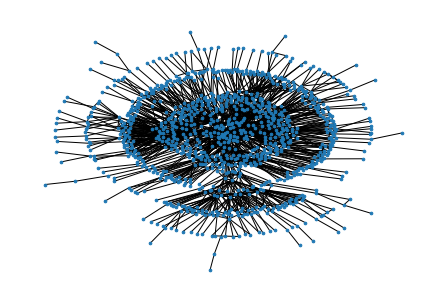

In [ ]:
nx.draw_kamada_kawai(V, node_size=7)

In [ ]:
degrees = [d for node, d in V.degree()]

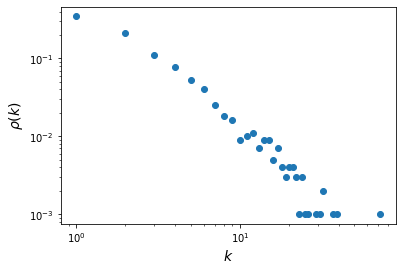

In [ ]:
plot_lin_degree_distribution(degrees)

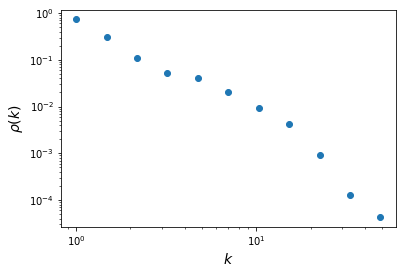

In [ ]:
plot_log_degree_distribution(degrees, 12)

In [ ]:
nx.average_clustering(V)

0.31745469466517556

## Dimension as a parameter

### d = 2

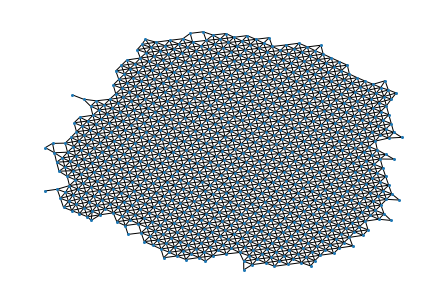

In [15]:
d = 2
emb = ba_space(1000, d)
V = emb_to_graph(emb)
degrees = [d for node, d in V.degree()]
nx.draw_kamada_kawai(V, node_size=4)

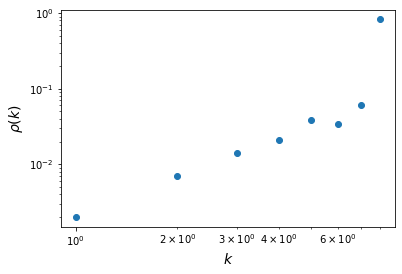

In [16]:
plot_lin_degree_distribution(degrees)

### d = 3

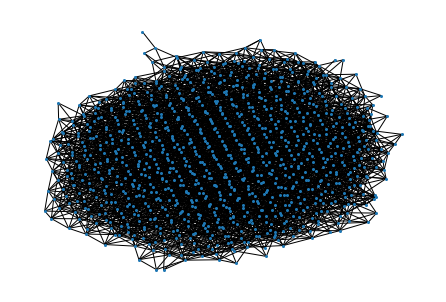

In [17]:
d = 3
emb = ba_space(1000, d)
V = emb_to_graph(emb)
degrees = [d for node, d in V.degree()]
nx.draw_kamada_kawai(V, node_size=4)

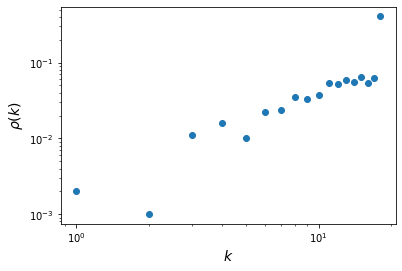

In [18]:
plot_lin_degree_distribution(degrees)

### d = 10

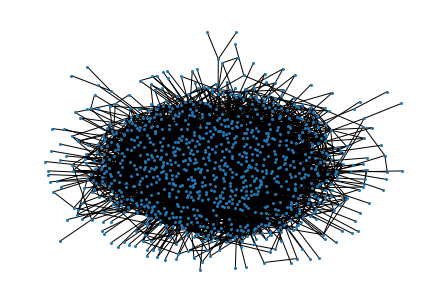

In [25]:
d = 10
emb = ba_space(1000, d)
V = emb_to_graph(emb)
degrees = [d for node, d in V.degree()]
nx.draw_kamada_kawai(V, node_size=4)

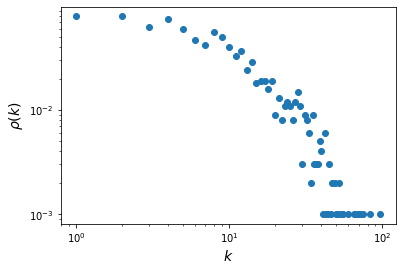

In [26]:
plot_lin_degree_distribution(degrees)

### d = 20

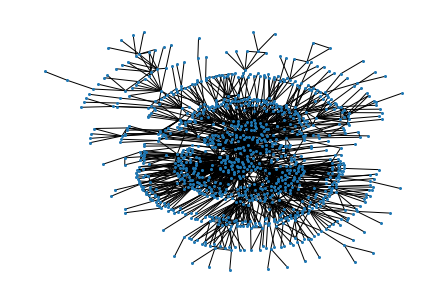

In [19]:
d = 20
emb = ba_space(1000, d)
V = emb_to_graph(emb)
degrees = [d for node, d in V.degree()]
nx.draw_kamada_kawai(V, node_size=4)

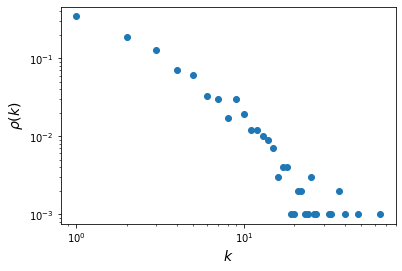

In [20]:
plot_lin_degree_distribution(degrees)

### d = 40

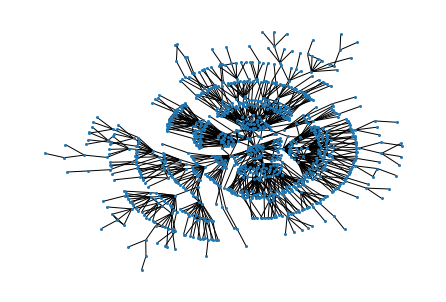

In [27]:
d = 40
emb = ba_space(1000, d)
V = emb_to_graph(emb)
degrees = [d for node, d in V.degree()]
nx.draw_kamada_kawai(V, node_size=4)

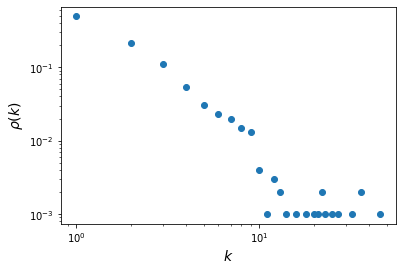

In [28]:
plot_lin_degree_distribution(degrees)

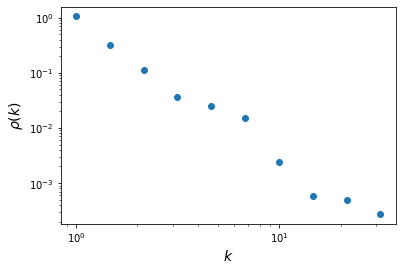

In [31]:
plot_log_degree_distribution(degrees, 11)

### d = 100

In [32]:
d = 100
emb = ba_space(1000, d)
V = emb_to_graph(emb)
degrees = [d for node, d in V.degree()]

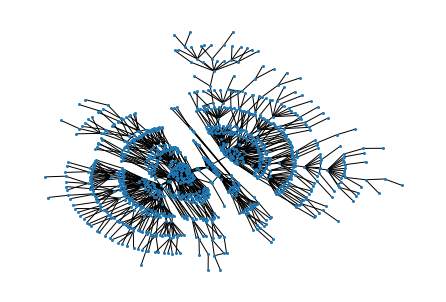

In [37]:
nx.draw_kamada_kawai(V, node_size=4)

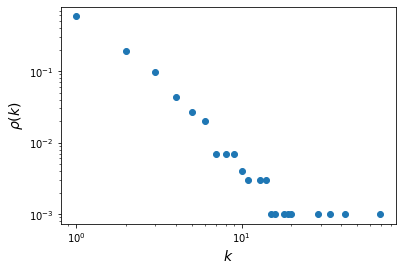

In [33]:
plot_lin_degree_distribution(degrees)

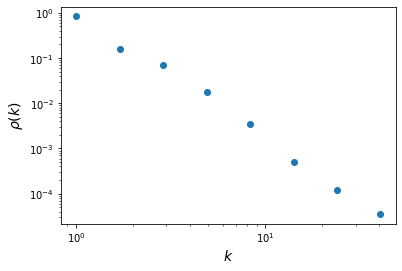

In [36]:
plot_log_degree_distribution(degrees, 9)

## Barabasi-Albert

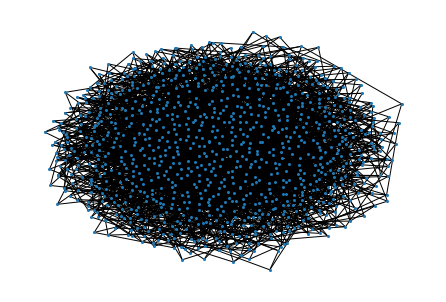

In [23]:
BA = nx.barabasi_albert_graph(1000, 3)
degrees = [d for node, d in BA.degree()]
nx.draw_kamada_kawai(BA, node_size=4)

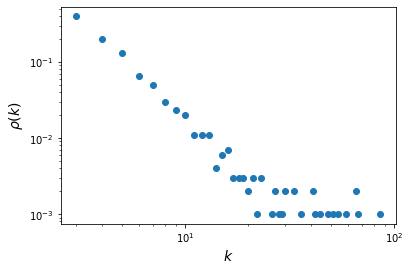

In [24]:
plot_lin_degree_distribution(degrees)